In [11]:
# Import packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as plm
import tensorflow as tf
from tensorflow.keras import layers

tf.__version__

'2.7.0'

# Setup input pipeline

In [12]:
os.listdir("/database/")

['pretrained',
 '1-billion-word-language-modeling-benchmark-r13output.tar.gz',
 'machine-translation-dataset',
 'card-fraud-dataset',
 'tweet-sentiment-span-dataset',
 'CMU_MOSEI.zip',
 'vqa',
 'tensorflow-datasets',
 'semeval-absa',
 'news-headline-dataset',
 'lfw',
 'CMU_MOSI.zip',
 'churn-dataset',
 'fec',
 'squad',
 'wiki-text',
 'amazon-reviews',
 'pcld']

In [13]:
# Dowload data (if already not done)
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True, cache_dir="/database/tensorflow-datasets/")

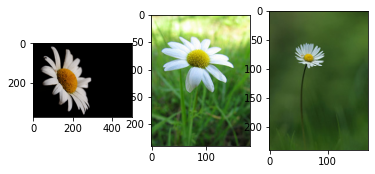

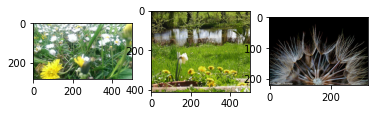

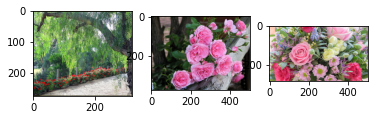

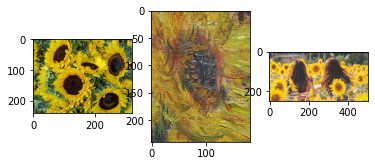

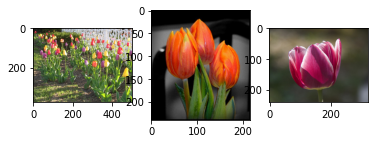

In [14]:
# View first 5 images
directory = os.listdir(data_dir)

for each in ["daisy", "dandelion", "roses", "sunflowers", "tulips"]:
    plt.figure()
    folder = data_dir + "/" + each
    if os.path.isdir(folder):
        for i, file in enumerate(os.listdir(folder)[0:3], start=1):
            fullpath = folder + "/" + file
            img = plm.imread(fullpath)
            plt.subplot(1, 3, i)
            plt.imshow(img)

In [15]:
# Define image size
img_height = 180
img_width = 180

# Create train and validation dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


2021-12-05 22:10:17.408362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 22:10:17.412412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 22:10:17.413033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 22:10:17.414051: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
# Class labels
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## View train and val dataset 

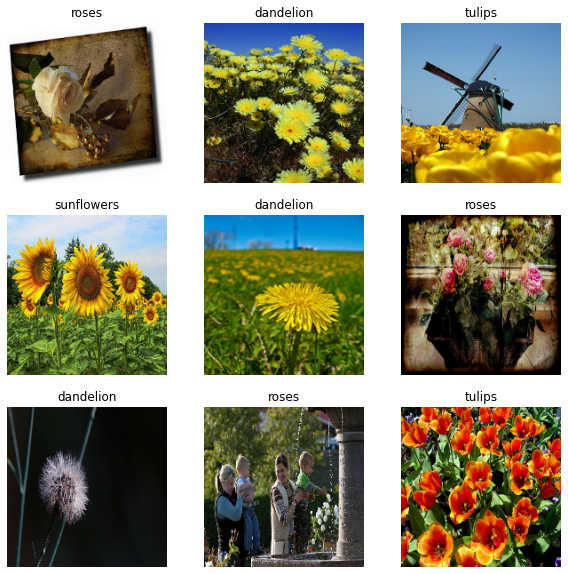

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

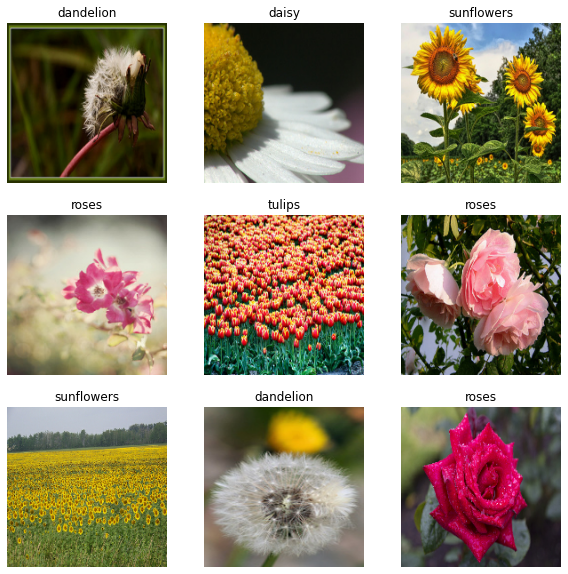

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Configure the dataset for performance

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data normalization layer

In [20]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

## Data augmentation layer

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)])

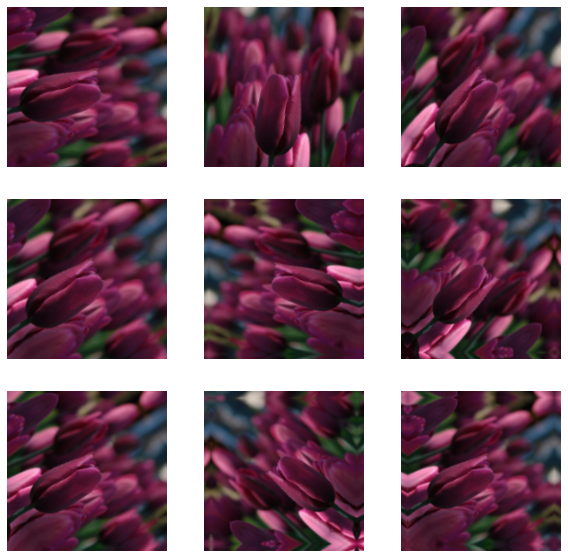

In [22]:
# View a few augmented images for examples
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

2021-12-05 22:10:27.446048: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


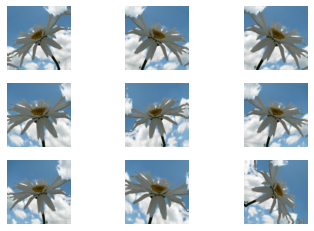

In [23]:
for images, _ in val_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Modelling

In [38]:
model = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(len(class_names))
])

# Compile model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

# View
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

In [39]:
# Create a early stopping hook
callback_hooks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)]

In [40]:
# Train and validate model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callback_hooks)

Epoch 1/100
92/92 [==============================] - 2s 20ms/step - loss: 1.3692 - accuracy: 0.4060 - val_loss: 1.1480 - val_accuracy: 0.5368
Epoch 2/100
92/92 [==============================] - 2s 18ms/step - loss: 1.1224 - accuracy: 0.5378 - val_loss: 1.0306 - val_accuracy: 0.5926
Epoch 3/100
92/92 [==============================] - 2s 18ms/step - loss: 1.0103 - accuracy: 0.6059 - val_loss: 1.0100 - val_accuracy: 0.5872
Epoch 4/100
92/92 [==============================] - 2s 18ms/step - loss: 0.9575 - accuracy: 0.6219 - val_loss: 1.0046 - val_accuracy: 0.6185
Epoch 5/100
92/92 [==============================] - 2s 18ms/step - loss: 0.8971 - accuracy: 0.6604 - val_loss: 0.8756 - val_accuracy: 0.6608
Epoch 6/100
92/92 [==============================] - 2s 18ms/step - loss: 0.8586 - accuracy: 0.6676 - val_loss: 0.9786 - val_accuracy: 0.6294
Epoch 7/100
92/92 [==============================] - 2s 18ms/step - loss: 0.8493 - accuracy: 0.6778 - val_loss: 0.9374 - val_accuracy: 0.6240
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


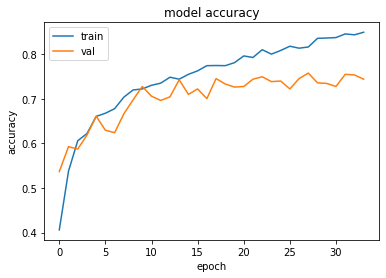

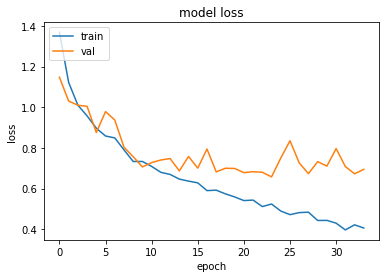

In [41]:
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# Summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()